# Run VGG16 on 30 classes with 120 epochs
Finally, we use the model from test2 to classify 30 artists' paintings with 120 epochs.

Obviously, the validation accuraccy is stable at more than %60, and the validation loss keep decreasing during the 120 epochs while keep reasonable difference between the training loss. 

Given that there are 30 classes and some of the artists have similar art style, the accuracy of 60% is an acceptable result.

In [1]:
import numpy as np
import os
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Flatten, Dense, GaussianNoise, BatchNormalization
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17738829143079950615
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2264907776
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18079149120323357725
physical_device_desc: "device: 0, name: GeForce GTX 970M, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


In [3]:
import tensorflow.keras.backend as K
K.clear_session()

In [4]:
nrow = 200
ncol = 200
nclass = 30
base_model = applications.VGG16(weights='imagenet', input_shape=(nrow,ncol,3), include_top=False)
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = GaussianNoise(0.1)(x)
x = Dropout(0.5)(x)
x = Dense(2304, activation = 'relu')(x) # 18432/4
x = GaussianNoise(0.1)(x) # add noise to mitigate overfitting (regularization layer)
x = Dropout(0.5)(x)
x = Dense(288, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
pred = Dense(nclass, activation='softmax', 
             kernel_initializer='random_uniform', 
             bias_initializer='random_uniform', 
             bias_regularizer=regularizers.l2(0.01), 
             name='predictions')(x) 
model = Model(inputs=base_model.input, outputs=pred)
    

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0         
__________

In [6]:
train_data_dir = './images_train'
batch_size = 5
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
                        train_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='categorical')

Found 5687 images belonging to 30 classes.


In [7]:
test_data_dir = './images_test'
batch_size = 5
test_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_generator = train_datagen.flow_from_directory(
                        test_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='categorical')

Found 1404 images belonging to 30 classes.


In [8]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
steps_per_epoch = train_generator.n // batch_size
validation_steps = test_generator.n // batch_size

In [9]:
nepochs = 120  # Number of epochs

# Call the fit_generator function
hist = model.fit_generator(
    train_generator,
    epochs=nepochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=validation_steps)

Instructions for updating:
Use tf.cast instead.
Epoch 1/120
1138/1138 [==============================] - 264s 232ms/step - loss: 3.1491 - acc: 0.1310 - val_loss: 2.5986 - val_acc: 0.2493
Epoch 2/120
1138/1138 [==============================] - 186s 164ms/step - loss: 2.8532 - acc: 0.1918 - val_loss: 2.4152 - val_acc: 0.3219
Epoch 3/120
1138/1138 [==============================] - 187s 165ms/step - loss: 2.6953 - acc: 0.2281 - val_loss: 2.2909 - val_acc: 0.3597
Epoch 4/120
1138/1138 [==============================] - 185s 163ms/step - loss: 2.6033 - acc: 0.2553 - val_loss: 2.2024 - val_acc: 0.3739
Epoch 5/120
1138/1138 [==============================] - 188s 165ms/step - loss: 2.4983 - acc: 0.2889 - val_loss: 2.0528 - val_acc: 0.4110
Epoch 6/120
1138/1138 [==============================] - 187s 164ms/step - loss: 2.4404 - acc: 0.3014 - val_loss: 2.0597 - val_acc: 0.4195
Epoch 7/120
1138/1138 [==============================] - 185s 163ms/step - loss: 2.3997 - acc: 0.3227 - val_loss: 1.97

Epoch 36/120
1138/1138 [==============================] - 183s 161ms/step - loss: 1.6868 - acc: 0.5200 - val_loss: 1.5842 - val_acc: 0.5491
Epoch 37/120
1138/1138 [==============================] - 184s 162ms/step - loss: 1.6421 - acc: 0.5237 - val_loss: 1.5852 - val_acc: 0.5591
Epoch 38/120
1138/1138 [==============================] - 185s 162ms/step - loss: 1.6653 - acc: 0.5270 - val_loss: 1.5856 - val_acc: 0.5499
Epoch 39/120
1138/1138 [==============================] - 182s 160ms/step - loss: 1.6182 - acc: 0.5356 - val_loss: 1.5595 - val_acc: 0.5548
Epoch 40/120
1138/1138 [==============================] - 183s 160ms/step - loss: 1.6038 - acc: 0.5474 - val_loss: 1.5700 - val_acc: 0.5399
Epoch 41/120
1138/1138 [==============================] - 182s 160ms/step - loss: 1.5994 - acc: 0.5455 - val_loss: 1.5830 - val_acc: 0.5655
Epoch 42/120
1138/1138 [==============================] - 183s 161ms/step - loss: 1.5481 - acc: 0.5646 - val_loss: 1.5646 - val_acc: 0.5627
Epoch 43/120
1138/11

1138/1138 [==============================] - 182s 160ms/step - loss: 1.2604 - acc: 0.6464 - val_loss: 1.4899 - val_acc: 0.5976
Epoch 73/120
1138/1138 [==============================] - 182s 160ms/step - loss: 1.3019 - acc: 0.6325 - val_loss: 1.5331 - val_acc: 0.5712
Epoch 74/120
1138/1138 [==============================] - 181s 159ms/step - loss: 1.2828 - acc: 0.6364 - val_loss: 1.5057 - val_acc: 0.5962
Epoch 75/120
1138/1138 [==============================] - 184s 162ms/step - loss: 1.2897 - acc: 0.6378 - val_loss: 1.4754 - val_acc: 0.5983
Epoch 76/120
1138/1138 [==============================] - 182s 160ms/step - loss: 1.2737 - acc: 0.6430 - val_loss: 1.5137 - val_acc: 0.5819
Epoch 77/120
1138/1138 [==============================] - 183s 161ms/step - loss: 1.2538 - acc: 0.6408 - val_loss: 1.4667 - val_acc: 0.5976
Epoch 78/120
1138/1138 [==============================] - 181s 159ms/step - loss: 1.2251 - acc: 0.6517 - val_loss: 1.4709 - val_acc: 0.5947
Epoch 79/120
1138/1138 [=========

Epoch 108/120
1138/1138 [==============================] - 183s 161ms/step - loss: 1.0640 - acc: 0.7030 - val_loss: 1.4327 - val_acc: 0.6189
Epoch 109/120
1138/1138 [==============================] - 183s 161ms/step - loss: 1.0284 - acc: 0.7134 - val_loss: 1.4449 - val_acc: 0.6040
Epoch 110/120
1138/1138 [==============================] - 182s 160ms/step - loss: 1.0495 - acc: 0.7009 - val_loss: 1.4678 - val_acc: 0.6147
Epoch 111/120
1138/1138 [==============================] - 184s 162ms/step - loss: 1.0915 - acc: 0.6965 - val_loss: 1.4707 - val_acc: 0.6161
Epoch 112/120
1138/1138 [==============================] - 183s 161ms/step - loss: 1.0362 - acc: 0.7086 - val_loss: 1.4195 - val_acc: 0.6168
Epoch 113/120
1138/1138 [==============================] - 184s 161ms/step - loss: 1.0618 - acc: 0.6984 - val_loss: 1.4723 - val_acc: 0.6054
Epoch 114/120
1138/1138 [==============================] - 183s 161ms/step - loss: 1.0605 - acc: 0.6977 - val_loss: 1.4361 - val_acc: 0.6189
Epoch 115/120

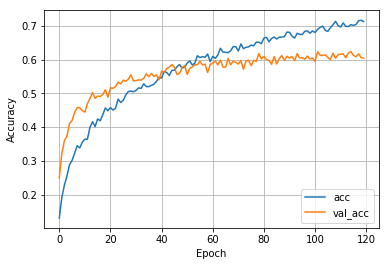

In [10]:
hist_his = hist.history
acc = hist_his['acc']
val_acc = hist_his['val_acc']
plt.plot(acc)
plt.plot(val_acc)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['acc','val_acc'], loc = 4)

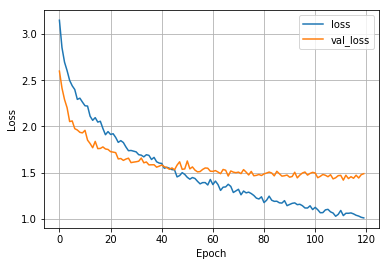

In [11]:
loss = hist_his['loss']
val_loss = hist_his['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['loss','val_loss'], loc = 1)

In [12]:
print(loss)
print(val_loss)
print(acc)
print(val_acc)

[3.14887666830137, 2.8532378607524054, 2.6948824729885055, 2.6039271128079124, 2.4979331421164566, 2.440019819100083, 2.399272446737613, 2.292742282639536, 2.30581997699429, 2.2634986593640707, 2.2238892891274116, 2.2204405017470945, 2.110854354446794, 2.0661793674560305, 2.0953340293737712, 2.047150615105546, 2.0561495057272956, 1.9780113589623198, 1.9103560941079305, 1.9441882107470394, 1.9133827449442402, 1.921118175116662, 1.881087851315784, 1.8279229860241224, 1.8463588798163497, 1.825864585407677, 1.7781568921490631, 1.7375602504637742, 1.7402194728693268, 1.7325628055971956, 1.7249106890065862, 1.69454954486751, 1.6893229365626559, 1.6710068310514494, 1.694082800954638, 1.687026359556177, 1.642625775837366, 1.6653471243717937, 1.6179302782737373, 1.6038959688491135, 1.5998659210237989, 1.547910915263533, 1.5579253501190502, 1.5476253076022677, 1.5329002478466693, 1.5308413288705227, 1.4540808080568326, 1.4685977000107093, 1.500136630329596, 1.481121332802734, 1.4495783738067454,